In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
inflows = pd.read_parquet('data/ucsd-inflows.pqt')
outflows = pd.read_parquet('data/ucsd-outflows.pqt')

display(inflows.head(), outflows.head())

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,MISCELLANEOUS,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,EXTERNAL_TRANSFER,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-07-29,EXTERNAL_TRANSFER


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES


## WEEK 2 - Train Test Split

In [3]:
# WEEK 2

In [4]:
from sklearn.model_selection import train_test_split

test_size = 0.2 

inflows_train, inflows_test = train_test_split(inflows, test_size=test_size, random_state=42)
outflows_train, outflows_test = train_test_split(outflows, test_size=test_size, random_state=42)

In [5]:
# need to sample by consumer instead of transaction

In [6]:
# Get unique customer_ids
ids = outflows.prism_consumer_id.unique()

# Split customer_ids into training and testing sets
train_ids, test_ids = train_test_split(ids, test_size=0.25)

In [90]:
outflows_train = outflows[outflows['prism_consumer_id'].isin(train_ids)]
outflows_test = outflows[outflows['prism_consumer_id'].isin(test_ids)]

In [8]:
outflows_train.shape, outflows_test.shape

((1943301, 6), (654187, 6))

In [9]:
print(f'# of unique IDS: {len(outflows.prism_consumer_id.unique())}, # of unique train IDS: {len(outflows_train.prism_consumer_id.unique())}, # of unique test IDS: {len(outflows_test.prism_consumer_id.unique())}')

# of unique IDS: 2968, # of unique train IDS: 2226, # of unique test IDS: 742


In [10]:
outflows.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount
count,2597488.00000,2597488.00000
mean,3084.22934,145.12640
std,1820.57135,1697.87473
min,0.00000,0.00000
25%,1369.00000,9.63000
50%,3245.00000,24.26000
75%,4733.00000,66.36000
max,5943.00000,654853.21000


In [11]:
outflows_train.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount
count,1943301.00000,1943301.00000
mean,3078.58982,148.69702
std,1827.06049,1691.47747
min,0.00000,0.00000
25%,1355.00000,9.65000
50%,3255.00000,24.23000
75%,4733.00000,66.22000
max,5943.00000,475000.00000


In [12]:
outflows_test.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount
count,654187.00000,654187.00000
mean,3100.98186,134.51965
std,1801.05438,1716.69508
min,2.00000,0.00000
25%,1437.00000,9.57000
50%,3236.00000,24.37000
75%,4761.00000,66.87000
max,5939.00000,654853.21000


In [13]:
# include statistical tests to ensure distributions are similar

## WEEK 3 - Memo Cleaning

In [14]:
outflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES


In [15]:
# steps:
## did more complex preprocessing first 
    # lemmatizer? (might not be good for this because it could stem words it shouldn't
    # same thing for stop words
    # remove dates (regex search mm/yy) and location addresses
    # get rid of email addresses -- TODO 
    # trans 1 @ $1.00 -- TODO
## simple preprocessing
    # lowercase 
    # remove punctuation (,-*#_')
    # remove XXXX, even amount of X's
    # remove purchase authorized on
    # remove purchase, checkcard
# should we preprocess memos that are the same as category? -- no

In [16]:
outflows.category.unique()

array(['LOAN', 'ATM_CASH', 'FOOD_AND_BEVERAGES', 'ENTERTAINMENT',
       'GENERAL_MERCHANDISE', 'ESSENTIAL_SERVICES', 'GROCERIES',
       'EXTERNAL_TRANSFER', 'AUTOMOTIVE', 'UNCATEGORIZED',
       'CREDIT_CARD_PAYMENT', 'SELF_TRANSFER', 'PETS',
       'HEALTHCARE_MEDICAL', 'INSURANCE', 'ACCOUNT_FEES',
       'HOME_IMPROVEMENT', 'TRAVEL', 'MORTGAGE', 'OVERDRAFT', 'EDUCATION',
       'RENT', 'TAX', 'CHILD_DEPENDENTS', 'GIFTS_DONATIONS',
       'BILLS_UTILITIES', 'PAYCHECK', 'BNPL', 'AUTO_LOAN'], dtype=object)

In [17]:
og_memos = outflows.loc[~(outflows.memo == outflows.category), 'memo']
memos = outflows.loc[~(outflows.memo == outflows.category), 'memo']

In [18]:
og_memos[og_memos.str.contains('@')].values[:1000]

array(['CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'PURCHASE XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'PURCHASE XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX',
       'Autoplicity LL support@autop',
       'MERCHANT BNKCD | FEE / | JUDITH WISWELL ATTY @LXXXXXXXXXXXX',
       'MERCHANT BNKCD | FEE / | JUDITH WISWELL ATTY @LXXXXXXXXXXXX',
       'MERCHANT BNKCD | FEE / | 

In [19]:
memos = memos.str.lower() \
    .str.replace(r'\b\w*x{2,}\w*\b', '', regex=True) \
    .str.replace(r'\b(0[1-9]|1[0-2])(\/|-)[0-9]{2}\b', '', regex=True) \
    .str.replace(r"[,'*#_-]", '', regex=True) \
    .str.replace(r'~', '', regex=True) \
    .str.replace('purchase.* authorized on', '', regex=True) \
    .str.replace('tst', '') \
    .str.replace('checkcard', '') \
    .str.strip()

In [20]:
test = memos.str.replace(r'trans \d+ @ \$\d+\.\d{2}', 'testing', regex=True)
test[(test.str.contains('@'))].values[:1000]

array(['gsuitebesmer. cc@google.comca  recurring',
       'purchase  scbjj scbjj dknakagawa@gmca  recurring',
       'gsuitebesmer. cc@google.comca  recurring',
       'purchase  scbjj scbjj dknakagawa@gmca  recurring',
       'gsuitebesmer. cc@google.comca  recurring',
       'scbjj scbjj dknakagawa@gmca  recurring',
       'scbjj scbjj dknakagawa@gmca  recurring',
       'scbjj scbjj dknakagawa@gmca  recurring',
       'gsuitebesmer. cc@google.comca', 'autoplicity ll support@autop',
       'merchant bnkcd | fee / | judith wiswell atty @',
       'merchant bnkcd | fee / | judith wiswell atty @',
       'merchant bnkcd | fee / | judith wiswell atty @',
       'merchant bnkcd | fee / | judith wiswell atty @',
       'merchant bnkcd | discount / | judith wiswell atty @',
       'merchant bnkcd | fee / | judith wiswell atty @',
       'merchant bnkcd | discount / | judith wiswell atty @',
       'merchant bnkcd | fee / | judith wiswell atty @',
       'merchant bnkcd | fee / | judith wisw

In [21]:
memos[(memos.str.contains('@'))].values[:1000]

array(['gsuitebesmer. cc@google.comca  recurring',
       'purchase  scbjj scbjj dknakagawa@gmca  recurring',
       'gsuitebesmer. cc@google.comca  recurring',
       'purchase  scbjj scbjj dknakagawa@gmca  recurring',
       'gsuitebesmer. cc@google.comca  recurring',
       'scbjj scbjj dknakagawa@gmca  recurring',
       'scbjj scbjj dknakagawa@gmca  recurring',
       'scbjj scbjj dknakagawa@gmca  recurring',
       'gsuitebesmer. cc@google.comca', 'autoplicity ll support@autop',
       'merchant bnkcd | fee / | judith wiswell atty @',
       'merchant bnkcd | fee / | judith wiswell atty @',
       'merchant bnkcd | fee / | judith wiswell atty @',
       'merchant bnkcd | fee / | judith wiswell atty @',
       'merchant bnkcd | discount / | judith wiswell atty @',
       'merchant bnkcd | fee / | judith wiswell atty @',
       'merchant bnkcd | discount / | judith wiswell atty @',
       'merchant bnkcd | fee / | judith wiswell atty @',
       'merchant bnkcd | fee / | judith wisw

In [22]:
outflows.loc[~(outflows.memo == outflows.category), 'memo'].unique().__len__(), memos.unique().__len__(), 

(528766, 307370)

In [23]:
og_memos_counts = og_memos.value_counts()
memos_counts = memos.value_counts()

In [24]:
og_memos_counts

memo
Amazon                                                                               31725
Walmart                                                                              31619
McDonald's                                                                           22670
Starbucks                                                                            12777
7-Eleven                                                                             11675
                                                                                     ...  
Doordash Kazu Sushi Bu                                                                   1
Par Gators Dockside -                                                                    1
Chilis Mandarin                                                                          1
Chilis Bay Meadows                                                                       1
POS WITHDRAWALWAL-MART #XXXX XXXX E MCKELLIPS RD MESA AZ  Card 15 #XXXX  MCC XXXX    

In [25]:
memos_counts

memo
walmart                                                          32099
amazon                                                           31737
mcdonalds                                                        27598
starbucks                                                        12823
7eleven                                                          11821
                                                                 ...  
eros  houston south houston tx  card                                 1
bosss bbq las vegas nv                                               1
eyebrows r us  flaming las vegas nv                                  1
vontronixtv fl                                                       1
pos withdrawalwalmart   e mckellips rd mesa az  card 15   mcc        1
Name: count, Length: 307370, dtype: int64

In [26]:
with open('memo_original.txt', 'w') as f:
    inspect = outflows.memo.unique()
    f.write(',\n'.join([str(x) for x in sorted(inspect)]))

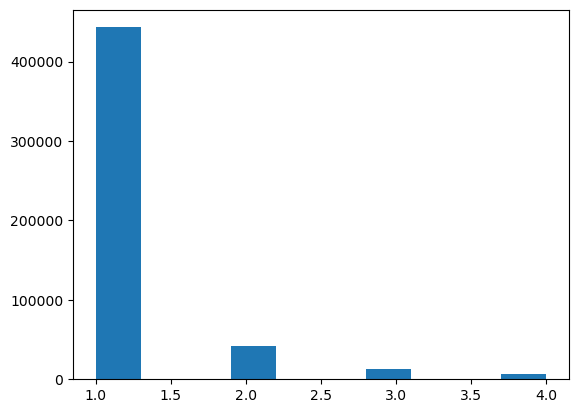

In [27]:
plt.hist(og_memos_counts[og_memos_counts < 5])
plt.show()

In [28]:
outflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES


In [29]:
(og_memos_counts == 1).sum()

443287

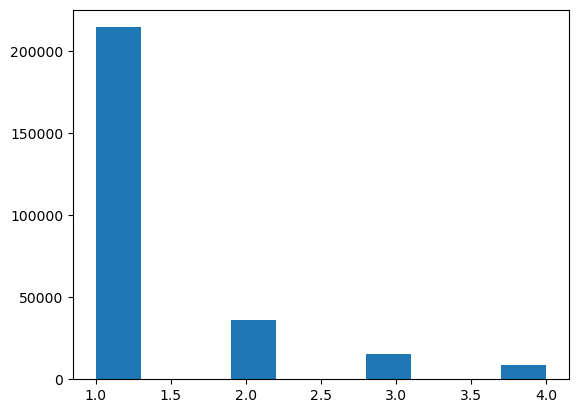

In [30]:
plt.hist(memos_counts[memos_counts < 5])
plt.show()

In [31]:
(memos_counts == 1).sum()

214687

## Week 4

### Creating Features

In [37]:
outflows.loc[~(outflows.memo == outflows.category), 'cleaned_memo'] = memos
outflows.loc[(outflows.memo == outflows.category), 'cleaned_memo'] = outflows.loc[(outflows.memo == outflows.category), 'memo']

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [96]:
corpus = outflows.cleaned_memo
vectorizer = TfidfVectorizer(max_features=50)
X = vectorizer.fit_transform(corpus)

In [97]:
vectorizer.get_feature_names_out()

array(['22', '7eleven', 'account_fees', 'amazon', 'amzn', 'apple',
       'atm_cash', 'automotive', 'az', 'bill', 'ca', 'card', 'cash',
       'check', 'co', 'com', 'credit_card_payment', 'date', 'debit',
       'dollar', 'entertainment', 'essential_services',
       'external_transfer', 'fl', 'ga', 'google', 'healthcare_medical',
       'id', 'insurance', 'loan', 'market', 'mcdonalds', 'mktp', 'ny',
       'of', 'on', 'payment', 'pos', 'purchase', 'recurring',
       'self_transfer', 'starbucks', 'target', 'tx', 'uber',
       'uncategorized', 'visa', 'wa', 'walmart', 'withdrawal'],
      dtype=object)

In [98]:
X_df = pd.DataFrame.sparse.from_spmatrix(X)

In [103]:
X_df.sum().sum()

2532949.578393844

In [100]:
# Get unique customer_ids
ids = outflows.prism_consumer_id.unique()

# Split customer_ids into training and testing sets
train_ids, test_ids = train_test_split(ids, test_size=0.25)

In [101]:
outflows_tf_idf = pd.concat([outflows, X_df], axis=1)

In [104]:
outflows_X = outflows_tf_idf.iloc[:, 7:]
outflows_y = outflows_tf_idf.loc[:, 'category']

In [106]:
train_series = outflows['prism_consumer_id'].isin(train_ids)
test_series = outflows['prism_consumer_id'].isin(test_ids)

In [114]:
outflows_X_train = outflows_X[train_series]
outflows_X_test = outflows_X[test_series]
outflows_y_train = outflows_y[train_series]
outflows_y_test = outflows_y[test_series]

### Training Models

#### Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression

In [116]:
clf = LogisticRegression(random_state=0).fit(outflows_X_train, outflows_y_train) # training took 3 minutes for 50 tfidf features

In [125]:
first_1000 = outflows_X_test.iloc[:1000]
first_1000

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
645,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
648,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
649,0,0,0,0,0,0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
first_1000_y = outflows_y_test.iloc[:1000]

In [128]:
preds_1000 = clf.predict(first_1000)

In [140]:
(first_1000_y == preds_1000).mean()

0.822

In [136]:
preds_all = clf.predict(outflows_X_test)

In [142]:
(outflows_y_test == preds_all).mean()

0.8306931015701737